# Evaluating BGP catchment on Tangled testbed
* Joao Ceron - ceron@botlog.org

In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import ticker
%matplotlib inline
from IPython.core.display import display, HTML
import os.path
import re
import numpy as pynum_float



In [3]:
# convert names to airport code
di = {"uk-lnd-anycast02": "LHR", 
      'us-mia-anycast01':"MIA", 
      "au-syd-anycast01":"SYD",
      'fr-par-anycast01': "CDG",
      'jp-hnd-anycast01': "HND",
      'br-poa-anycast01': "POA",
      'us-was-anycast01': "IAD",
      'us-los-anycast01': "LAX",
      "nl-ens-anycast02": "ENS",
      'vultr-nodes' : 'vultr-nodes',
      'ampath-nodes' : 'ampath-nodes',
      'unknown': 'unknown',
      'baseline': 'baseline',
      'all': 'baseline',
     }
di_short = {
      "uk-lnd": "LHR", 
      'us-mia':"MIA", 
      "au-syd":"SYD",
      'fr-par': "CDG",
      'jp-hnd': "HND",
      'br-poa': "POA",
      'us-was': "IAD",
      'us-los': "LAX", 
      'nl-ens': "ENS",
      'vultr-nodes' : 'vultr-nodes',
      'ampath-nodes' : 'ampath-nodes',
      'unknown': 'unknown',
      'baseline': 'baseline',
      'all': 'baseline'
}

In [4]:
# plt.style.available[:5]

---
---
<h1 align="center">Functions</h1>

---
---

In [5]:
def init_fig(width=12,height=5):
    
    fig = plt.figure(figsize=(width, height))
    ax = plt.subplot(111)   
    ax.set_facecolor("#ffffff")
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    fig.tight_layout();
    plt.style.use('default')
    
    return (fig,ax)

In [6]:
def get_and_plot_reference_value(df,site):

    
    df_site = df[df['site']==site].sort_values(by="bgp")
    reference_value = df_site[df_site.bgp=="baseline"].iloc[0,2]

    label = "[{}%] BASELINE".format(int(reference_value))
    # reference value annotation
    ax.annotate(label,xy=(25, reference_value), ha='right',color='black',va='bottom')
    # reference value line
    ax.axhline(y=reference_value, xmin=-1, xmax=1.0, color='grey', linestyle='dotted')

    return (reference_value)

In [7]:
!pwd

/Users/joaoceron/work/SAND/paper_bgp_catchment_manipulation/data_analysis/server_load


---
---
<h1 align="center">Read files and build dataframe</h1>

---
---

In [8]:
# get files, parse them and use their names
df_all = pd.DataFrame()

# dir   = "./stats_files/load-2019-12-06-1575649928/*load*.txt"
dir   = "./stats_files/load-stats/*load*.txt"
# dir   = "/Volumes/4T/dataset/2020-01-28-1580170039/load/*load*txt"
# /Volumes/4T/dataset/last/load
# dir = "/Volumes/4T/dataset/last/load/*load*.txt"
# dir = "/Users/ceron/work/SAND/catchment_manipulation/load-stats/*load*.txt"
# dir = "/Users/joaoceron/work/SAND/catchment_manipulation/load-stats/*load*.txt"
# dir = "/tmp/*load*.txt"

count = 0
for file in (glob.glob(dir)):
    count +=1
    filename = os.path.basename(file)
#     print ("working on file: {}".format(filename))
    
    
    # read header of stats load file
    fd = open(file, 'r') 
    for line in fd.readlines():
        if ("date" in line):
            id = line.split(",")[1].rstrip('\n')
        elif ("bgp_policy" in line):
            bgp = line.split(",")[1].rstrip('\n')
        elif ("active_nodes" in line):
            active_nodes = line.split(",")[1].rstrip('\n')
    ###
    ### BUILD Dataframe using load files 
    ###
    #1 - process the baseline stats file - regular prefixes announcemnt
    if (bool(re.search('baseline', filename))):     
        df = pd.read_csv(file,names=['site', 'count','percent'],skiprows=4)       
        df['bgp_policy'] = "baseline"
        df['time'] = id
        df['bgp_policy_location'] = "all"
        df['num_prepend'] = 0
        df['community'] = "None"
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        df_all = pd.concat([df, df_all],sort=False) 
        
    # 2 - process prepend files
    elif re.search(r'(?=.*\bprepend\b.*)(?!.*\bvultr\b.*)(?!.*\bcommunity\b.*)(?!.*\bampath\b.*).*$', filename, re.M):

        df = pd.read_csv(file,names=['site', 'count','percent'],skiprows=4)  
        site = re.search('.*(\w{2}-\w+)-anycast\d{2}', bgp).group(1)
        num_prepend = int(re.search('.*-(\d)x-.*anycast\d{2}', bgp).group(1))

        if (bool(re.search('negative', bgp))):
            num_prepend = num_prepend*-1

        df['bgp_policy'] = "prepend"
        df['time'] = id
        df['bgp_policy_location'] = site
        df['num_prepend'] = num_prepend
        df['community'] = "None"
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        df_all = pd.concat([df, df_all],sort=False) 
            
    # 3 - process communities load files
    elif re.search(r'(?=.*\bcommunit\b.*)(?!.*\bvultr\b.*)(?!.*\bampath\b.*).*$', filename, re.M):
            
        print ("community {}".format(filename))
        df = pd.read_csv(file,names=['site', 'count','percent'],skiprows=4)  
        site = re.search('.*(\w{2}-\w+)-anycast\d{2}', bgp).group(1)
        community = (re.search('community-([0-9:,]+)-\w\w-.*cast\d\d',bgp).group(1))
        df['bgp_policy'] = "community"
        df['time'] = id
        df['bgp_policy_location'] = site
        df['num_prepend'] = 0
        df['community'] = community
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        df_all = pd.concat([df, df_all],sort=False) 

    # 4 - node withdraw
    elif (bool(re.search('-withdraw', filename))): 
        df = pd.read_csv(file,names=['site', 'count','percent'],skiprows=4)  
        site = re.search('.*(\w{2}-\w+)-anycast\d{2}', bgp).group(1)
        df['bgp_policy'] = bgp
        df['time'] = id
        df['bgp_policy_location'] = site
        df['num_prepend'] = 0
        df['community'] = "None"
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        df_all = pd.concat([df, df_all],sort=False) 

    # vultr prepending
    elif re.search(r'(?=.*\bprepend\b.*)(?=.*\bvultr\b.*).*$', filename, re.M):
        df = pd.read_csv(file,names=['site', 'count','percent'], skiprows=4)  
        df['time'] = id
        df['bgp_policy_location'] = "vultr-nodes"
        df['num_prepend'] = int(re.search('.*-(\d)x-.*node.*', bgp).group(1))
        df['community'] = "None"
        bgp = "-".join(str(x) for x in bgp.split("-")[0:2]).replace('-regular_positive','')
        df['bgp_policy'] = bgp
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        found = df[df['count']==500034]['count']
        if (int(found.count())>0):
            print ("vultr prepending")
        df_all = pd.concat([df, df_all],sort=False) 

        
    # ampath prepending
    elif re.search(r'(?=.*\bprepend\b.*)(?=.*\bampath\b.*).*$', filename, re.M): 
        df = pd.read_csv(file,names=['site', 'count','percent'], skiprows=4)
        df['time'] = id
        df['bgp_policy_location'] = "ampath-nodes"
        df['num_prepend'] = int(re.search('.*-(\d)x-.*node.*', bgp).group(1))
        df['community'] = "None"
        bgp = "-".join(str(x) for x in bgp.split("-")[0:2]).replace('-regular_positive','')
        df['bgp_policy'] = bgp
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3) 
        df_all = pd.concat([df, df_all],sort=False) 
    else:
        print ("ignored file {}".format(file))
    
print ("Files loaded: {}".format(count))
df=df_all
df['site']  =  df['site'].map(di)
df['bgp_policy_location']  =  df['bgp_policy_location'].map(di_short)


# df.to_csv("catchment-load-communities-prepend.csv", sep=';')

# remove prepend vs community prepend experiment from df (keep on df_all)
# df = df[~df['bgp_policy_location'].str.contains("nodes")]
df_all.head()

ignored file ./stats_files/load-stats/load-new-#ipv4,au-syd-2020-01-31-1580512204.txt
ignored file ./stats_files/load-stats/load-new-#ipv4,jp-hnd-2020-01-31-1580512204.txt
ignored file ./stats_files/load-stats/load-new-#ipv4,br-poa-2020-01-31-1580512204.txt
ignored file ./stats_files/load-stats/load-new-community-20473:6601-uk-lnd-anycast02-1580512204.txt
ignored file ./stats_files/load-stats/load-new-#ipv4,us-mia-2020-01-31-1580512204.txt
ignored file ./stats_files/load-stats/load-new-#ipv4,fr-par-2020-01-31-1580512204.txt
ignored file ./stats_files/load-stats/load-new-#ipv4,us-was-2020-01-31-1580512204.txt
ignored file ./stats_files/load-stats/load-new-#ipv4,uk-lnd-2020-01-31-1580512204.txt
ignored file ./stats_files/load-stats/load-new-community-20473:6601-au-syd-anycast01-1580512204.txt
Files loaded: 101


site   count  percent                 time bgp_policy_location  num_prepend  \
0  LHR  958927   15.580  2020-02-07-09:22:17        ampath-nodes            1   
1  SYD  775705   12.603  2020-02-07-09:22:17        ampath-nodes            1   
2  POA  726593   11.805  2020-02-07-09:22:17        ampath-nodes            1   
3  IAD  514483    8.359  2020-02-07-09:22:17        ampath-nodes            1   
4  CDG  281950    4.581  2020-02-07-09:22:17        ampath-nodes            1   

  community bgp_policy  
0      None    prepend  
1      None    prepend  
2      None    prepend  
3      None    prepend  
4      None    prepend

In [9]:
!pwd

/Users/joaoceron/work/SAND/paper_bgp_catchment_manipulation/data_analysis/server_load


---
---
<h1 align="center">Baseline Catchment</h1>

---
---

/Users/joaoceron/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


count  percent                 time bgp_policy_location  \
site                                                                 
LHR       796172   12.936  2020-01-31-23:10:04            baseline   
POA       714439   11.608  2020-01-31-23:10:04            baseline   
SYD       584351    9.494  2020-01-31-23:10:04            baseline   
MIA       543614    8.832  2020-01-31-23:10:04            baseline   
IAD       520290    8.453  2020-01-31-23:10:04            baseline   
CDG       245800    3.994  2020-01-31-23:10:04            baseline   
HND            1    0.000  2020-01-31-23:10:04            baseline   
unknown  2750121   44.683  2020-01-31-23:10:04            baseline   

         num_prepend community bgp_policy  
site                                       
LHR                0      None   baseline  
POA                0      None   baseline  
SYD                0      None   baseline  
MIA                0      None   baseline  
IAD                0      None   baseline  
CDG                0      None   baseline  
HND                0      None   baseline  
unknown            0      None   baseline

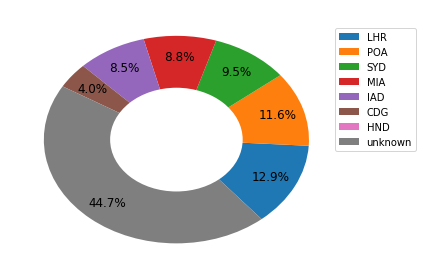

In [10]:

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot2grid((1,1), (0,0))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if (val==0):
            return ""
        return '{p:.1f}%'.format(p=pct,v=val)
    return my_autopct

result = df[df['bgp_policy'].str.contains("baseline")].copy()
result.set_index('site',inplace=True)
result.plot(ax=ax, 
            y='percent',
            autopct=make_autopct(result['count']),
            startangle=-50, 
            pctdistance=0.8, 
            kind="pie",
            fontsize=12,
            labels=None)

labels=result.index
ax.legend(labels, loc='upper center', bbox_to_anchor=(1.1,0.95))

centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle);
ax.set_ylabel('')
fig.tight_layout()
fig.show()
result

---
---
<h1 align="center">Catchment investigation using prepends</h1>

---
---

# OVERALL

## A - positive prepend

In [11]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data
# # data = data[data['num_prepend']=0]
# # data[data.bgp_policy_location=="HND"]580228
# # data[data['count'==580228]]
# data[data['count']==500034]

site    count  percent                 time bgp_policy_location  \
0       LHR   958927   15.580  2020-02-07-09:22:17        ampath-nodes   
1       SYD   775705   12.603  2020-02-07-09:22:17        ampath-nodes   
2       POA   726593   11.805  2020-02-07-09:22:17        ampath-nodes   
3       IAD   514483    8.359  2020-02-07-09:22:17        ampath-nodes   
4       CDG   281950    4.581  2020-02-07-09:22:17        ampath-nodes   
..      ...      ...      ...                  ...                 ...   
3       MIA   308049    5.005  2020-01-31-23:10:04                 CDG   
4       LHR   299281    4.863  2020-01-31-23:10:04                 CDG   
5       SYD    44260    0.719  2020-01-31-23:10:04                 CDG   
6       HND        1    0.000  2020-01-31-23:10:04                 CDG   
7   unknown  2778687   45.147  2020-01-31-23:10:04                 CDG   

    num_prepend community bgp_policy  
0             1      None    prepend  
1             1      None    prepend  
2             1      None    prepend  
3             1      None    prepend  
4             1      None    prepend  
..          ...       ...        ...  
3            -3      None    prepend  
4            -3      None    prepend  
5            -3      None    prepend  
6            -3      None    prepend  
7            -3      None    prepend  

[676 rows x 8 columns]

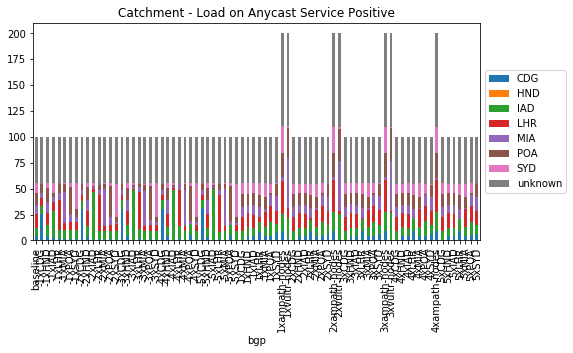

In [12]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
# data = data[data['num_prepend']>=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot2grid((1,1), (0,0))
data.plot(ax=ax,
          kind='bar', 
          stacked=True,
         );
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
ax.set_title("Catchment - Load on Anycast Service Positive".format(site));  


# data['sites'] = "5-sites"
# data.to_csv("5sites.csv")

In [13]:
# data['CDG_CAT'] = pd.cut(data['CDG'],[0,10,20,30,40,50,60,70,80,90,100], include_lowest=True)
# data.head()

In [14]:
data.dtypes

site
CDG        float64
HND        float64
IAD        float64
LHR        float64
MIA        float64
POA        float64
SYD        float64
unknown    float64
dtype: object

In [15]:
# del data['CDG_CAT']

In [16]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
data

site         CDG  HND     IAD     LHR     MIA     POA     SYD  unknown
bgp                                                                   
baseline   3.994  0.0   8.453  12.936   8.832  11.608   9.494   44.683
-1xCDG    25.450  0.0   8.050   7.199   5.359   8.083   0.773   45.085
-1xHND     3.824  0.0  10.597  12.341  10.399  13.028   5.127   44.685
-1xIAD     2.297  0.0  26.239   8.245   5.166   3.757   9.670   44.626
-1xLHR     1.332  0.0   8.260  29.726   6.810   7.998   0.827   45.047
...          ...  ...     ...     ...     ...     ...     ...      ...
5xIAD      3.902  0.0   7.814  13.985   8.764  10.869   9.216   45.449
5xLHR      8.893  0.0  11.724   0.000  10.065  13.429  10.781   45.109
5xMIA      4.257  0.0   9.171  16.453   1.285  11.165  12.452   45.218
5xPOA      4.984  0.0  12.832  15.192  10.814   1.602   9.576   45.000
5xSYD      6.674  0.0   8.330  13.883  13.427  11.796   0.793   45.096

[78 rows x 8 columns]

In [17]:
# a = data.apply(lambda x: pd.cut(x,[0,10,20,30,40,50,60,70,80,90,100], include_lowest=True)) 
# a.fillna(pd.categorical("(0, 10]"))
# a.add_categories("(0, 10]").fillna("(0, 10]")
# b = a.reset_index()
# pd.pivot_table(b,index=["site"],values=['count'],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1)
b =data.reset_index()
b.head(1)

site       bgp    CDG  HND    IAD     LHR    MIA     POA    SYD  unknown
0     baseline  3.994  0.0  8.453  12.936  8.832  11.608  9.494   44.683

In [18]:
for site in b.columns[1:]:
#     print (site)
    low = 90
    upper = 100
    size = b[(b.loc[:,['bgp',site]][site]>=low) & (b.loc[:,['bgp',site]][site]<upper) ][site]
    print ("{}-{}  {} {} ".format(low,upper, site,len(size)))
    b[(b.loc[:,['bgp',site]][site]>=low) & (b.loc[:,['bgp',site]][site]<upper) ][site]

90-100  CDG 0 
90-100  HND 0 
90-100  IAD 0 
90-100  LHR 0 
90-100  MIA 0 
90-100  POA 0 
90-100  SYD 0 
90-100  unknown 5 


#### site = "CDG"
b[(b.loc[:,['bgp',site]][site]>10) & (b.loc[:,['bgp',site]][site]<100) ][site]

In [19]:
for index, row in b.iterrows():
    print (row['bgp'],)

baseline
-1xCDG
-1xHND
-1xIAD
-1xLHR
-1xMIA
-1xPOA
-1xSYD
-2xCDG
-2xHND
-2xIAD
-2xLHR
-2xMIA
-2xPOA
-2xSYD
-3xCDG
-3xHND
-3xIAD
-3xLHR
-3xMIA
-3xPOA
-3xSYD
-4xCDG
-4xHND
-4xIAD
-4xLHR
-4xMIA
-4xPOA
-4xSYD
-5xCDG
-5xHND
-5xIAD
-5xLHR
-5xMIA
-5xPOA
-5xSYD
1xCDG
1xHND
1xIAD
1xLHR
1xMIA
1xPOA
1xSYD
1xampath-nodes
1xvultr-nodes
2xCDG
2xHND
2xIAD
2xLHR
2xMIA
2xPOA
2xSYD
2xampath-nodes
2xvultr-nodes
3xCDG
3xHND
3xIAD
3xLHR
3xMIA
3xPOA
3xSYD
3xampath-nodes
3xvultr-nodes
4xCDG
4xHND
4xIAD
4xLHR
4xMIA
4xPOA
4xSYD
4xampath-nodes
5xCDG
5xHND
5xIAD
5xLHR
5xMIA
5xPOA
5xSYD


## B - negative prepend

site         CDG  HND     IAD     LHR     MIA     POA     SYD  unknown
bgp                                                                   
baseline   3.994  0.0   8.453  12.936   8.832  11.608   9.494   44.683
-1xCDG    25.450  0.0   8.050   7.199   5.359   8.083   0.773   45.085
-1xHND     3.824  0.0  10.597  12.341  10.399  13.028   5.127   44.685
-1xIAD     2.297  0.0  26.239   8.245   5.166   3.757   9.670   44.626
-1xLHR     1.332  0.0   8.260  29.726   6.810   7.998   0.827   45.047
-1xMIA     0.917  0.0   8.811   7.113  29.841   8.291   0.678   44.349
-1xPOA     1.313  0.0   8.454   8.197   7.755  25.670   3.879   44.732
-1xSYD     1.372  0.0   8.712   7.553   4.969   7.778  24.769   44.847
-2xCDG    30.227  0.0   8.019   5.386   5.076   5.497   0.723   45.072
-2xHND     3.436  0.0  10.486  14.464  10.846  12.043   3.976   44.750
-2xIAD     0.552  0.0  46.106   2.712   2.007   1.295   2.798   44.529
-2xLHR     1.100  0.0   8.167  34.762   4.786   4.331   0.680   46.174
-2xMIA     0.644  0.0   8.593   4.971  34.986   5.746   0.676   44.385
-2xPOA     1.073  0.0   8.124   5.981   6.975  30.342   3.000   44.504
-2xSYD     0.821  0.0   8.703   6.074   2.303   5.196  31.855   45.048
-3xCDG    30.436  0.0   8.252   4.863   5.005   5.578   0.719   45.147
-3xHND     3.953  0.0  10.796  13.494  11.053  11.694   4.219   44.791
-3xIAD     0.433  0.0  47.937   1.706   1.725   1.250   2.483   44.467
-3xLHR     1.081  0.0  10.273  35.277   5.217   2.350   0.678   45.125
-3xMIA     0.641  0.0   8.591   4.861  34.096   5.696   0.671   45.445
-3xPOA     1.059  0.0   8.061   5.468   4.912  33.110   2.846   44.544
-3xSYD     0.812  0.0   8.651   5.844   2.259   5.185  32.345   44.904
-4xCDG    30.661  0.0   8.306   4.726   4.969   5.592   0.697   45.049
-4xHND     3.791  0.0   8.985  13.109  12.909  11.741   4.519   44.945
-4xIAD     0.428  0.0  48.578   1.339   1.724   1.221   2.316   44.395
-4xLHR     1.102  0.0  12.362  35.343   5.246   0.147   0.679   45.121
-4xMIA     0.604  0.0   8.590   4.836  34.843   5.656   0.670   44.800
-4xPOA     4.805  0.0  10.602   0.000   3.055  34.186   2.721   44.631
-4xSYD     0.863  0.0   8.685   5.730   2.223   5.111  32.421   44.967
-5xCDG    31.334  0.0   7.823   4.722   4.756   5.564   0.696   45.105
-5xHND     3.769  0.0   8.551  13.605  13.031  11.665   4.550   44.828
-5xIAD     0.427  0.0  48.995   0.935   1.718   1.218   2.314   44.393
-5xLHR     1.011  0.0   7.511  35.178   4.755   5.832   0.677   45.036
-5xMIA     0.600  0.0   8.067   4.811  35.802   5.683   0.669   44.366
-5xPOA     4.837  0.0  10.093   0.000   3.518  34.170   2.707   44.676
-5xSYD     0.799  0.0   8.185   5.844   2.223   5.106  32.452   45.390

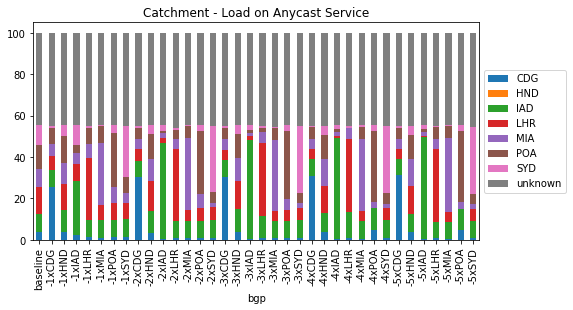

In [20]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data = data[data['num_prepend']<=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot2grid((1,1), (0,0))
data.plot(ax=ax,
          kind='bar', 
          stacked=True,
         );
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
ax.set_title("Catchment - Load on Anycast Service".format(site));  
data

## C. Impact of path prepending in catchment 

245800.0


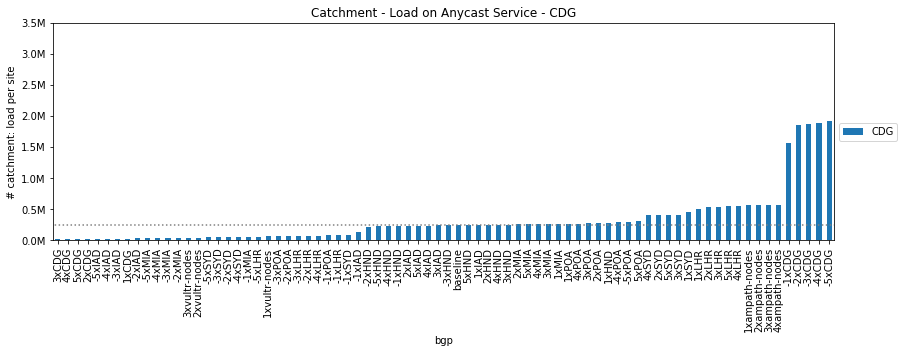

1.0


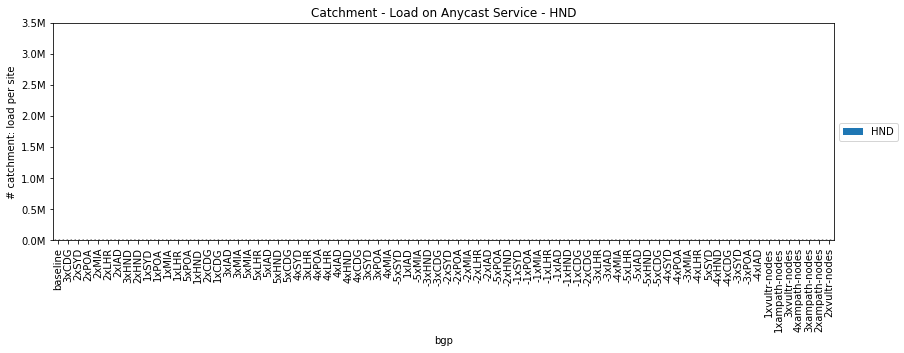

520290.0


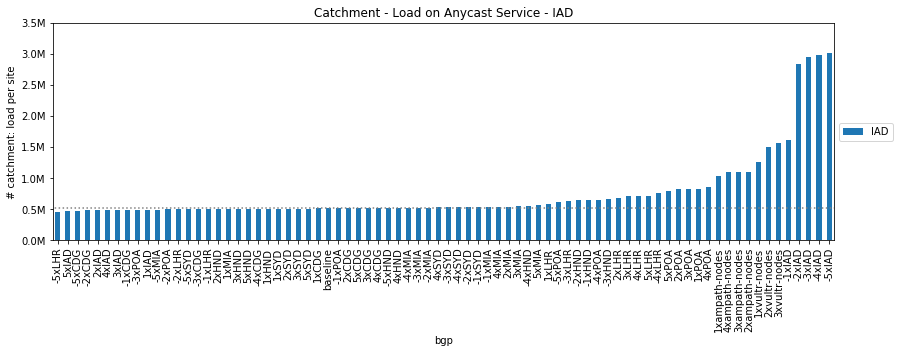

796172.0


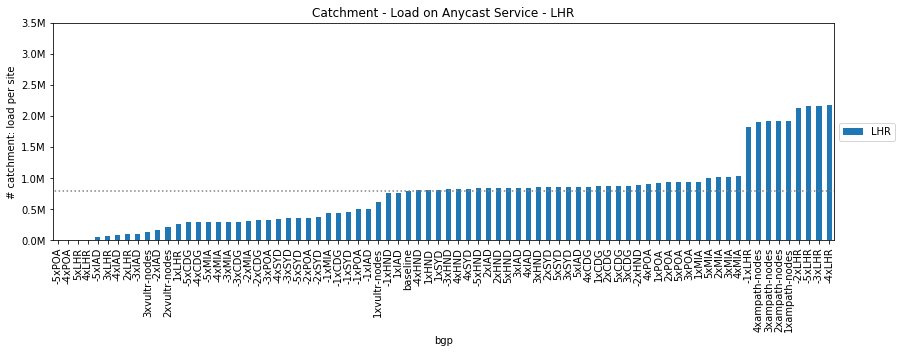

543614.0


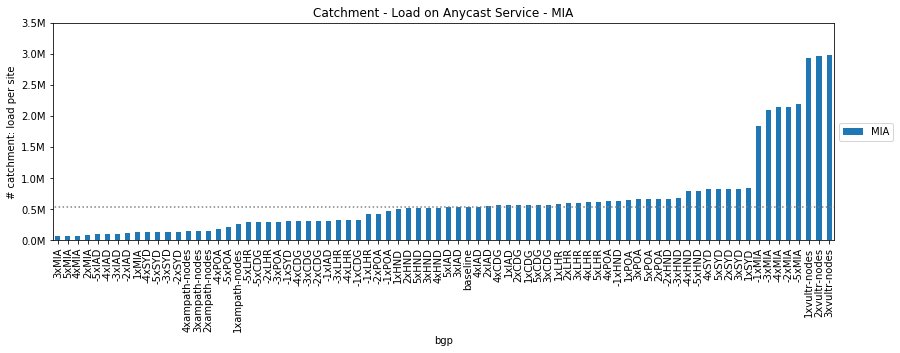

714439.0


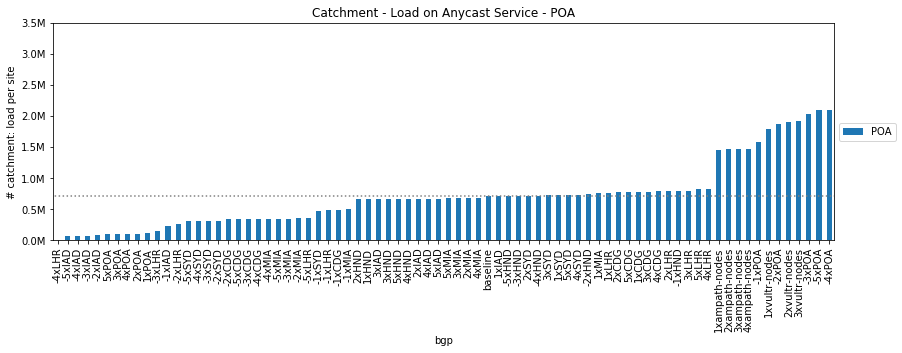

584351.0


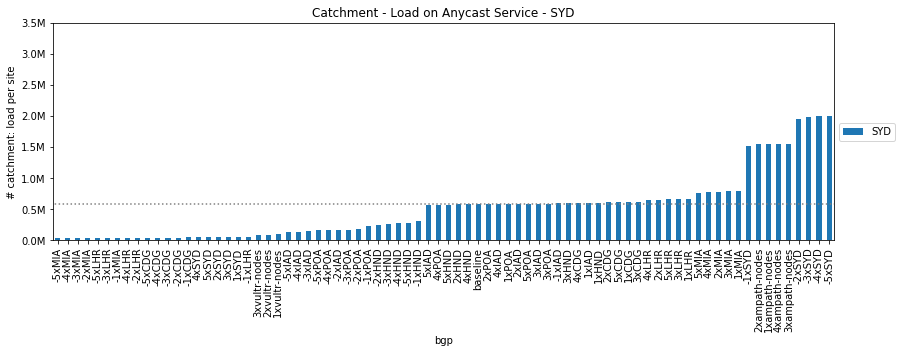

2750121.0


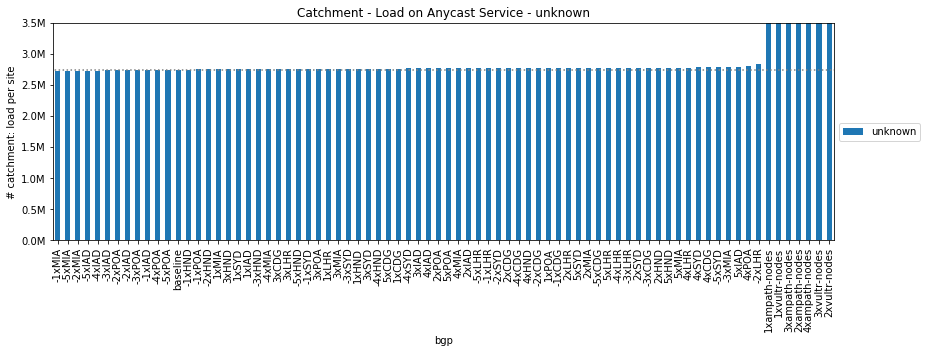

In [21]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
# data = data[data['num_prepend']>=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
columns_name = data.columns.get_level_values(0)

for col in columns_name:
    
    fig = plt.figure(figsize=(14, 4))
    ax = plt.subplot2grid((1,1), (0,0))
    
    data_site = data.loc[:,col].sort_values()
#     data_site = data.loc[:,col] 

    data_site.plot(ax=ax,
          kind='bar', 
          stacked=True,
         );
    df_site = data_site.reset_index()
    reference_value = data_site.reset_index()[df_site.bgp=="baseline"].iloc[0,1]
    print (reference_value)

   # label = "[{}%] BASELINE".format(int(reference_value))
   # ax.annotate(label,xy=(25, reference_value), ha='right',color='black',va='bottom')
    ax.axhline(y=reference_value, xmin=-1, xmax=1.0, color='grey', linestyle='dotted')
    
    ax.set_ylim(ymax=3500000, ymin=0);
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
#     ax.set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])

    ax.set_title("Catchment - Load on Anycast Service - {}".format(col));  
    ax.set_ylabel('# catchment: load per site');
    title = "<h2 style=\"color:#069\" >How prepending affects the load of site: {} </h2>".format(col.upper())
    display(HTML(title))
    plt.show()
    

## same values, another visualization

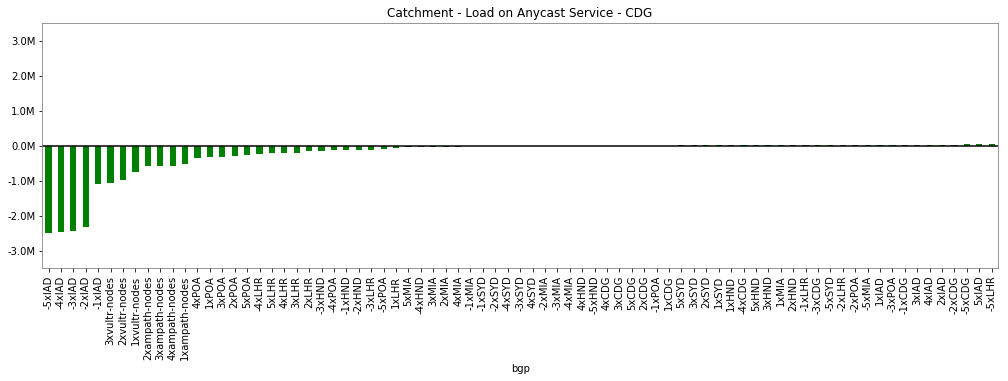

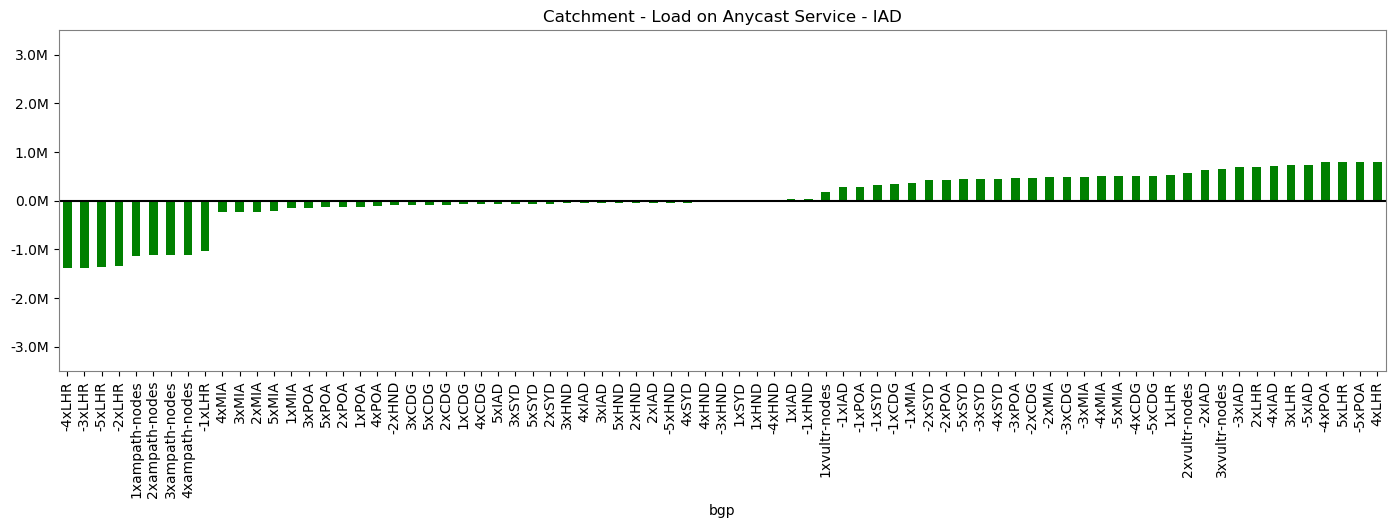

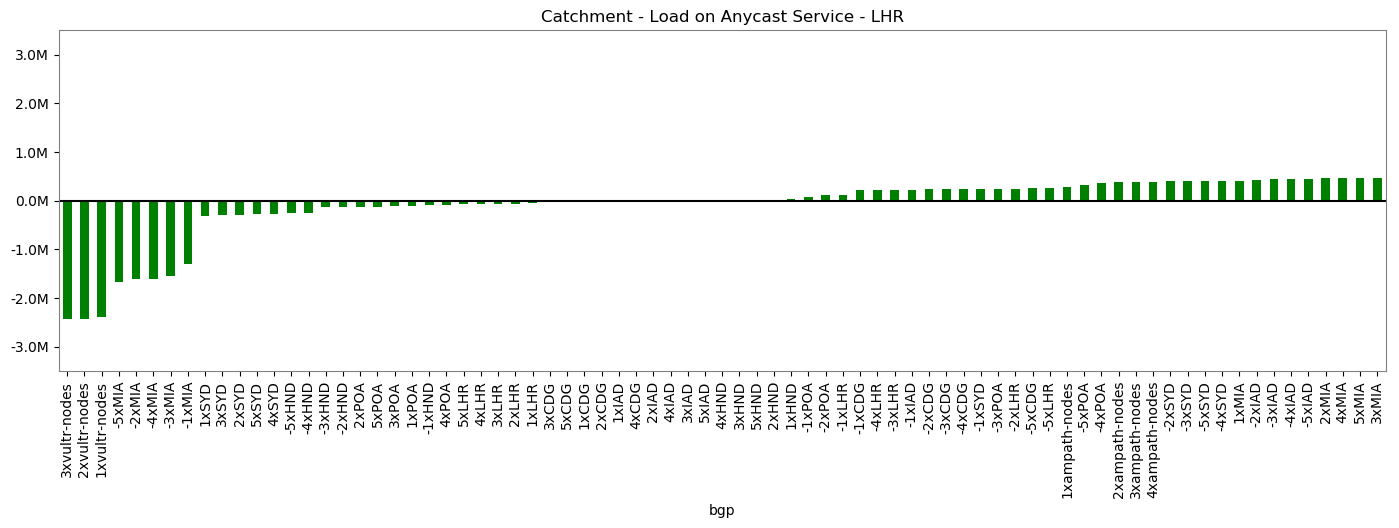

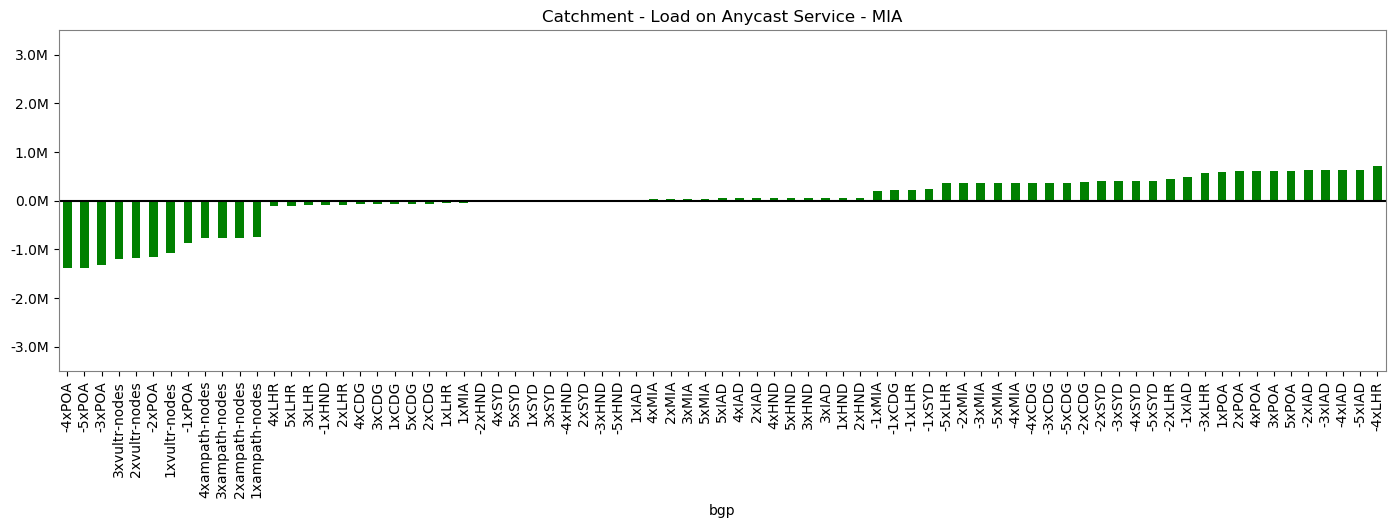

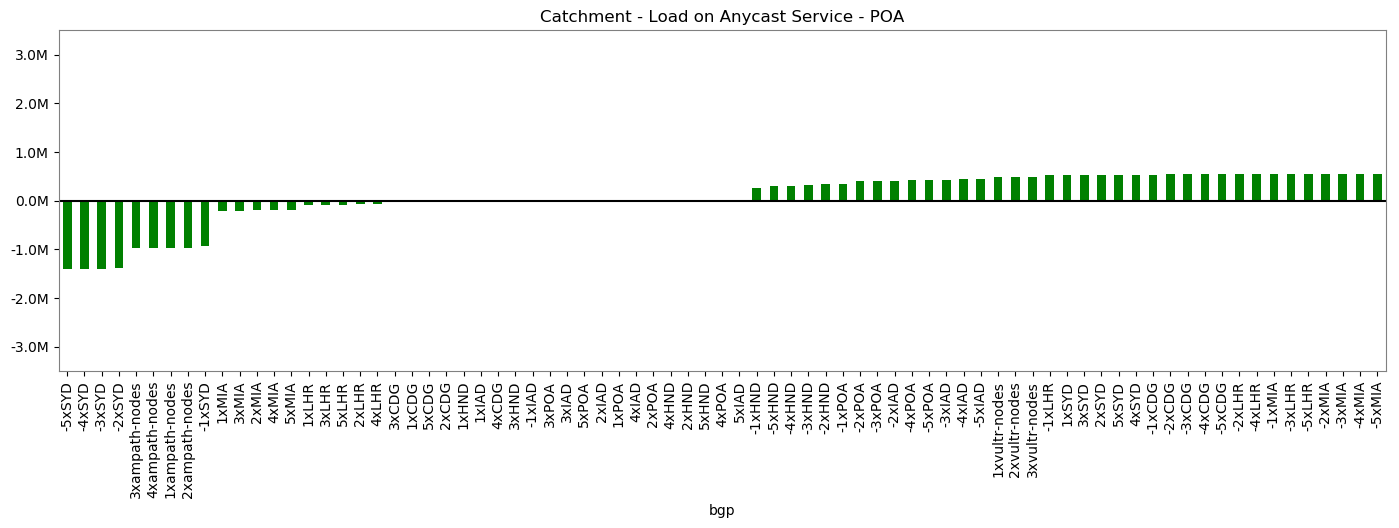

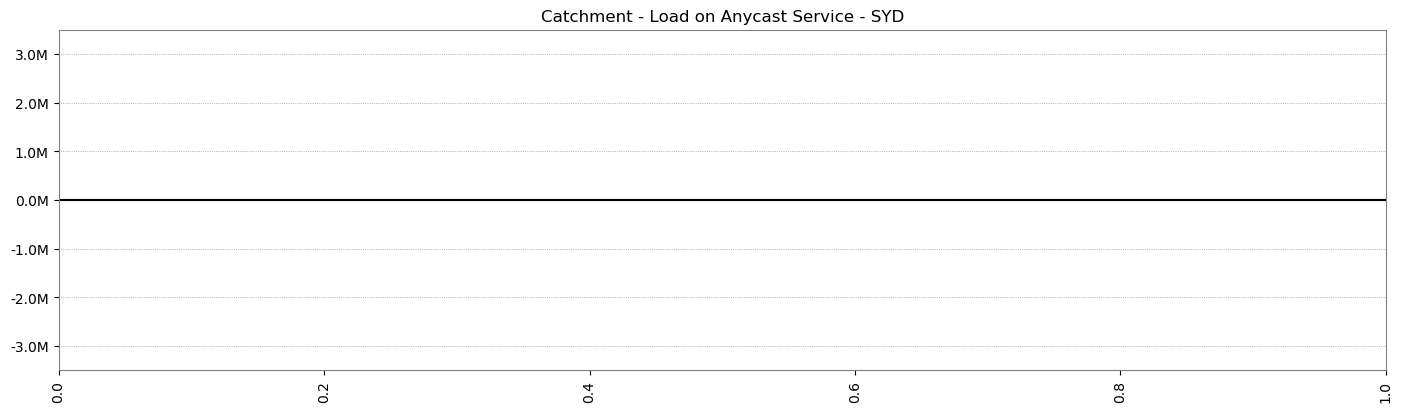

In [22]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")

data.drop('HND',1,inplace=True)
data.drop('unknown',1,inplace=True)    
columns_name = data.columns.get_level_values(0)

for site in columns_name:
    baseline  = data.iloc[[0]].values[0]
    data_diff = data.iloc[1:].apply(lambda x: (baseline-x), axis=1)  
    data_diff[site].sort_values().plot(kind="bar",ax=ax, stacked=False,color="green")

    (fig,ax) = init_fig(14,4)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels,rotation=90);
    ax.set_ylim(ymax=3500000,ymin=-3500000);
    ax.axhline(y=0, xmin=-1, xmax=1.0, color="black")
    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
    ax.set_title("Catchment - Load on Anycast Service - {}".format(site)); 
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()]); 

## Leandro's Idea
## Anycast Service maximum and minimum

In [23]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
# data = data[data['num_prepend']>=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")

# fix column names
data.columns=data.columns.get_level_values(0)
data.columns = data.columns.to_list()
df_prepend = data
df_prepend.head()

CDG  HND        IAD        LHR       MIA       POA       SYD  \
bgp                                                                            
baseline   245800.0  1.0   520290.0   796172.0  543614.0  714439.0  584351.0   
-1xCDG    1566418.0  1.0   495453.0   443092.0  329853.0  497518.0   47549.0   
-1xHND     235341.0  1.0   652208.0   759538.0  640007.0  801860.0  315584.0   
-1xIAD     141394.0  1.0  1614949.0   507450.0  317966.0  231234.0  595158.0   
-1xLHR      81971.0  1.0   508383.0  1829601.0  419133.0  492276.0   50899.0   

            unknown  
bgp                  
baseline  2750121.0  
-1xCDG    2774904.0  
-1xHND    2750249.0  
-1xIAD    2746636.0  
-1xLHR    2772524.0

In [24]:
data = pd.DataFrame()
regex_prepend_site = "prepend|baseline|with|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()

data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data.columns = data.columns.get_level_values(0).tolist()
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
data.to_csv("prepend+withdraw-dataframe.csv",sep=";")

In [25]:
data.head()

CDG  HND        IAD        LHR       MIA       POA       SYD  \
bgp                                                                            
baseline   245800.0  1.0   520290.0   796172.0  543614.0  714439.0  584351.0   
-1xCDG    1566418.0  1.0   495453.0   443092.0  329853.0  497518.0   47549.0   
-1xHND     235341.0  1.0   652208.0   759538.0  640007.0  801860.0  315584.0   
-1xIAD     141394.0  1.0  1614949.0   507450.0  317966.0  231234.0  595158.0   
-1xLHR      81971.0  1.0   508383.0  1829601.0  419133.0  492276.0   50899.0   

            unknown  
bgp                  
baseline  2750121.0  
-1xCDG    2774904.0  
-1xHND    2750249.0  
-1xIAD    2746636.0  
-1xLHR    2772524.0

In [26]:
data = pd.DataFrame()
regex_prepend_site = "prepend|baseline|with|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()

data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data.columns = data.columns.get_level_values(0).tolist()
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
data.to_csv("prepend+withdraw-dataframe-percent.csv",sep=";")
data.head()

CDG  HND     IAD     LHR     MIA     POA    SYD  unknown
bgp                                                                  
baseline   3.994  0.0   8.453  12.936   8.832  11.608  9.494   44.683
-1xCDG    25.450  0.0   8.050   7.199   5.359   8.083  0.773   45.085
-1xHND     3.824  0.0  10.597  12.341  10.399  13.028  5.127   44.685
-1xIAD     2.297  0.0  26.239   8.245   5.166   3.757  9.670   44.626
-1xLHR     1.332  0.0   8.260  29.726   6.810   7.998  0.827   45.047

In [27]:
pwd

'/Users/joaoceron/work/SAND/paper_bgp_catchment_manipulation/data_analysis/server_load'

In [28]:
df[df['bgp_policy'].str.contains("withdraw-au-syd-anycast01")]

site    count  percent                 time bgp_policy_location  \
0      MIA   829334   13.475  2020-02-05-12:54:36                 SYD   
1      LHR   823306   13.377  2020-02-05-12:54:36                 SYD   
2      POA   724302   11.768  2020-02-05-12:54:36                 SYD   
3      IAD   519713    8.444  2020-02-05-12:54:36                 SYD   
4      CDG   470715    7.648  2020-02-05-12:54:36                 SYD   
5      HND        1    0.000  2020-02-05-12:54:36                 SYD   
6  unknown  2787417   45.289  2020-02-05-12:54:36                 SYD   

   num_prepend community                 bgp_policy  
0            0      None  withdraw-au-syd-anycast01  
1            0      None  withdraw-au-syd-anycast01  
2            0      None  withdraw-au-syd-anycast01  
3            0      None  withdraw-au-syd-anycast01  
4            0      None  withdraw-au-syd-anycast01  
5            0      None  withdraw-au-syd-anycast01  
6            0      None  withdraw-au-syd-anycast01

### Extract MAX/MIN/BASELINE from prepend dataframe for each node

In [29]:
# get max value per line
max_policy_label = data.T.idxmax(axis=1)
max_policy_value=data.T.max(axis=1)

# get min value per line
min_policy_label = data.T.idxmin(axis=1)
min_policy_value=data.T.min(axis=1)

# get baseline values
df_baseline = data.iloc[0,:]

# build dataframe
df_result = pd.concat([max_policy_value,
                       min_policy_value,
                       df_baseline,max_policy_label,
                       min_policy_label],
                       axis=1
                     ) 
df_result.columns=['max','min','baseline','max_label','min_label']
# remove nodes
df_result = df_result[df_result.index!="unknown"]
df_result = df_result[df_result.index!="HND"]

max  min  baseline      max_label min_label
CDG  31.334  0.0     3.994         -5xCDG     0xCDG
IAD  48.995  0.0     8.453         -5xIAD     0xIAD
LHR  35.343  0.0    12.936         -4xLHR    -4xPOA
MIA  48.471  0.0     8.832  3xvultr-nodes     0xMIA
POA  34.186  0.0    11.608         -4xPOA     0xPOA
SYD  32.452  0.0     9.494         -5xSYD     0xSYD

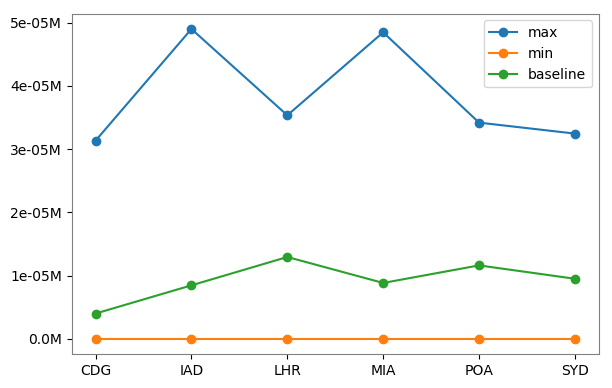

In [30]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)   
ax = plt.subplot2grid((1,1), (0,0))

ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
fig.tight_layout();
plt.style.use('default')

df_result[['max','min','baseline']].plot(marker='o',ax=ax)
ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])

df_result

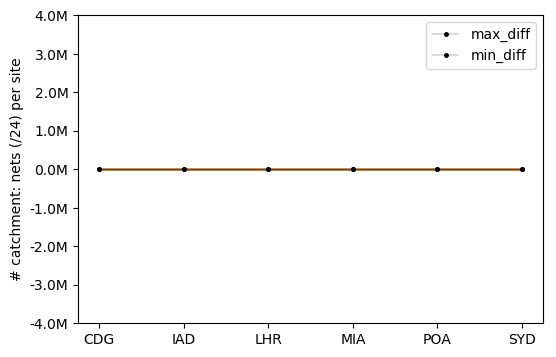

In [31]:
df_result['max_diff'] = (df_result['max'] - df_result['baseline'])   + df_result['baseline']
df_result['min_diff'] = (df_result['min'] - df_result['baseline'] ) - df_result['baseline']
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot2grid((1,1), (0,0))
df_result[['max_diff','min_diff']].plot(kind='area',ax=ax,alpha=0.8)
df_result[['min_diff']].plot(kind='line',marker=".",
                             markersize=5,
                             color="black",
                              linewidth=0.2,
                             ax=ax,legend=[])
df_result[['max_diff']].plot(kind='line',marker=".",
                             markersize=5,
                             color="black",
                              linewidth=0.2,
                             ax=ax,legend=[])
ax.set_ylim(ymax=4000000, ymin=-4000000);
ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()]);
ax.set_ylabel('# catchment: nets (/24) per site');
# ax2 = ax.twinx()
# ax.get_yticks().tolist()


In [32]:
# data_site.iloc[0:1][0]
# data_site[data_site.iloc[0]=="baseline"]

df_site = data_site.reset_index()
reference_value = data_site.reset_index()[df_site.bgp=="baseline"].iloc[0,1]
reference_value

2750121.0

---
---
<h1 align="center">Effect of prepeding on each site</h1>

---
---

In [33]:
available_nodes = df_prepend.columns.to_list()
available_nodes.remove('unknown')
available_nodes.remove('HND')
available_nodes

['CDG', 'IAD', 'LHR', 'MIA', 'POA', 'SYD']

CDG


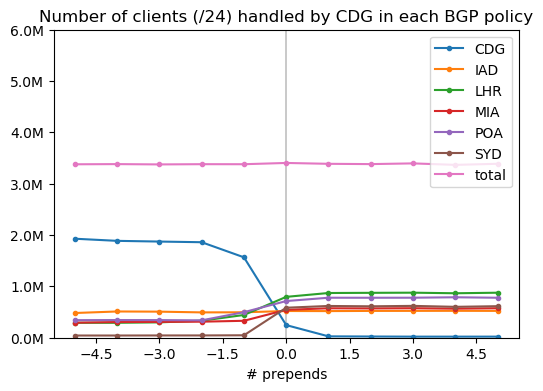

IAD


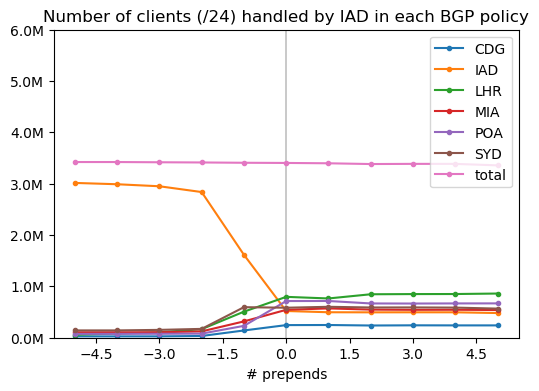

LHR


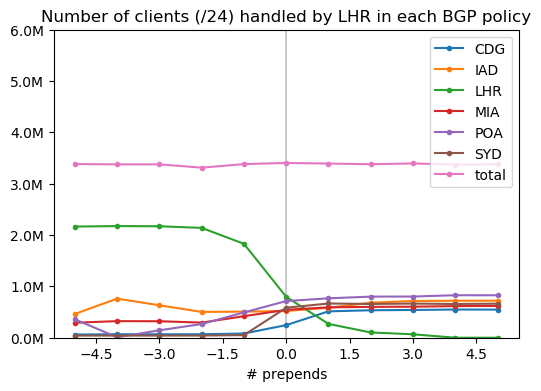

MIA


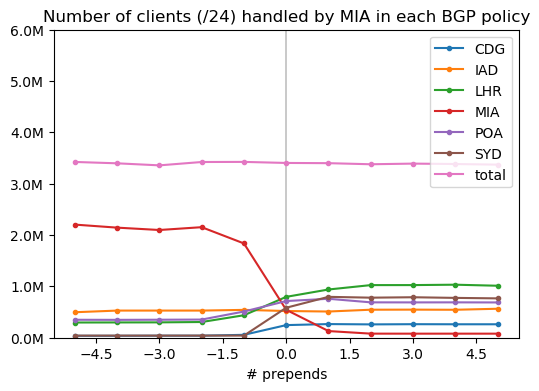

POA


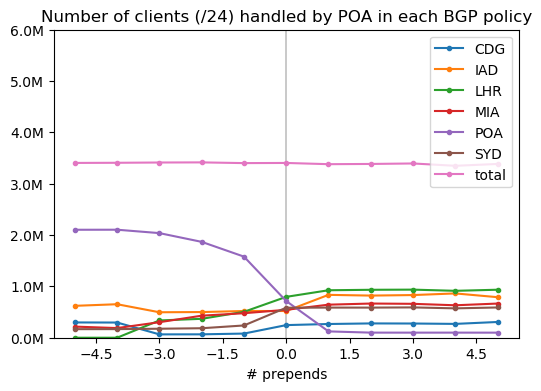

SYD


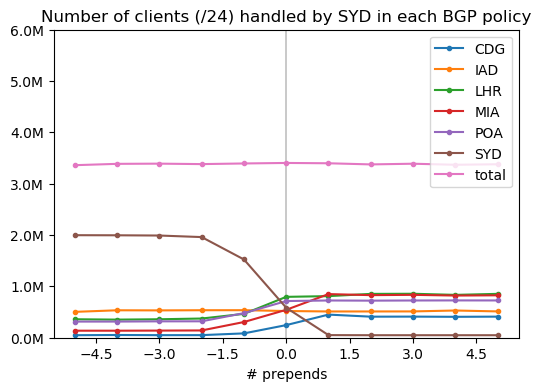

In [34]:
for prepend_site in available_nodes:

    data = df_prepend.copy()
    print (prepend_site)
    # prepare dataframe
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)]
    data.drop('HND',1,inplace=True)
    data.drop('unknown',1,inplace=True)
    data.reset_index(inplace=True)
    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    data['total'] = data.sum(axis=1)
    
    # prepare graph
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot(111)   
    ax.set_ylim(ymax=6000000);
    ax.axvline(x=0, color='black',linewidth=0.3)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    data.plot(kind="line",ax=ax, marker=".")
    ax.set_xlabel('# prepends');
    ax.set_title("Number of clients (/24) handled by {} in each BGP policy".format(prepend_site));   
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    plt.show()

---
---
<h1 align="center">Effect of self-prepending on all the sites</h1>

---
---

In [35]:
available_nodes = df_prepend.columns.to_list()
available_nodes.remove('unknown')
available_nodes.remove('HND')
available_nodes

['CDG', 'IAD', 'LHR', 'MIA', 'POA', 'SYD']

entrou
#77CCCC
entrou
#114477
entrou
#DDAA77
entrou
#CC99BB
entrou
#771155


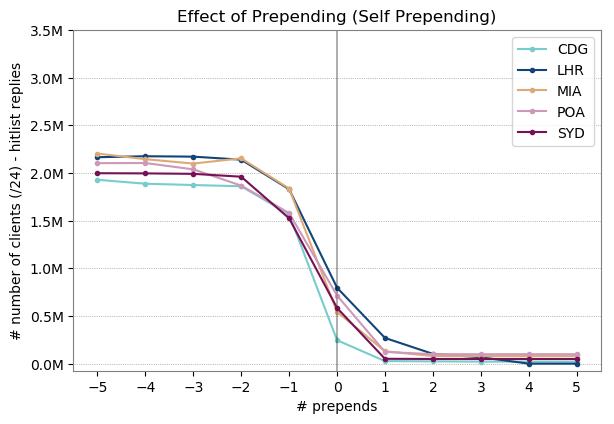

In [59]:
(fig,ax) = init_fig(6,4)
ax.set_title("Effect of Prepending (Self Prepending)")

mycolor = ["#77CCCC", "#114477", "#DDAA77", "#CC99BB", "#771155"]

i = 0 
for prepend_site in available_nodes:
# for prepend_site in  ['CDG']: 

    
    print ("entrou")

    # prepare dataset
    data = df_prepend.copy()
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)][prepend_site]
    self_prepending = data
    data = data.reset_index()

    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    
    print (mycolor[i])
    # 'CDG' lc rgb "#77CCCC"
   #  'LHR' lc rgb "#114477"
   # 'MIA' lc "#DDAA77"
   # 'POA' lc rgb "#CC99BB"
   # 'SYD' lc rgb "#771155"


    # plot graph
    data.plot(kind="line",
              marker=".",
              color = mycolor[i],
              ax= ax)
    i =  i+1
    ax.set_ylim(ymax=3500000);
    ax.axvline(x=0, color='black',linewidth=0.1)
    ax.xaxis.set_major_locator(plt.MaxNLocator(11))
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    ax.set_ylabel('# number of clients (/24) - hitlist replies');

    ax.set_xlabel('# prepends');

#     filename = "/Users/joaoceron/work/WORKING/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/self_prepending_tangled.pdf"
    filename = "/tmp/test.pdf"
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    fig.savefig(filename, bbox_inches='tight', dpi=1200)

    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
    

In [37]:
data = df_prepend.copy()
data.head()
data.drop('unknown',1,inplace=True)
data['total'] = data.sum(axis=1)
data
data_percent = pd.DataFrame()
data_percent['bgp'] = data.index
data = data.reset_index()
data_percent
data.head()

for node in data.columns[1:8]:
    node_pct = "{}_pct".format(node)
    data_percent[node] = (data[node]/data['total']).mul(100).round(3)
data_percent.head(1)
data_percent.set_index('bgp',inplace=True)
# data_percent

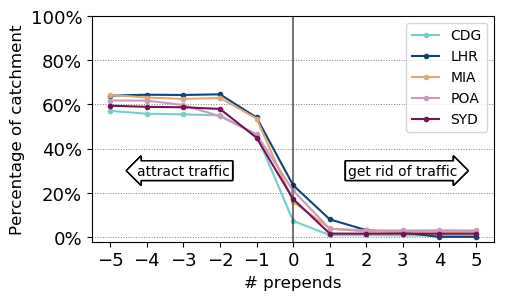

In [62]:
# (fig,ax) = init_fig(6,4)

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot2grid((1,1), (0,0))
mycolor = ["#77CCCC", "#114477", "#DDAA77", "#CC99BB", "#771155"]
i = 0
# ax.set_title("Effect of Prepending (Self Prepending)",fontsize=14)
available_nodes = ['CDG', 'LHR', 'MIA', 'POA', 'SYD']
# CDG	HND	LAX	LHR	MIA	SYD
# available_nodes = ['CDG', 'LHR']
for prepend_site in available_nodes:
# for prepend_site in  ['CDG']: 

    # prepare dataset
    data = data_percent.copy()
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)][prepend_site]
    self_prepending = data
    data = data.reset_index()

    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    
    
    # plot graph
    data.plot(kind="line",
              marker=".",
              color = mycolor[i],
              ax= ax)
    i = i+1
    ax.axvline(x=0, color='black',linewidth=0.2)
    ax.xaxis.set_major_locator(plt.MaxNLocator(11))
    ax.set_ylabel('Percentage of catchment',fontsize=12);
#     ax.set_xlim(xmax=5);
    ax.set_xlabel('# prepends',fontsize=12);
    ax.set_ylim(ymax=100);
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);
 
    filename = "/Users/joaoceron/work/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/self_prepending_tangled.pdf"
#     ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
#     fig.savefig(filename, bbox_inches='tight', dpi=1200)
    bbox_props = dict(boxstyle="larrow,pad=0.2", fc="white", ec="k", lw=1)
    ax.text(-3, 30, "attract traffic", ha="center", va="center", rotation=0,size=10, bbox=bbox_props)
    
    fig.tight_layout();

    bbox_props = dict(boxstyle="rarrow,pad=0.2", fc="white", ec="k", lw=1)
    ax.text(3, 30, "get rid of traffic", ha="center", va="center", rotation=0,size=10, bbox=bbox_props)
    plt.tick_params(axis='x', labelsize=13)
    plt.tick_params(axis='y', labelsize=13)
#     plt.legend(loc='upper left', bbox_to_anchor=(0, 0));

#     ax.axhline(y=20, xmin=-1, xmax=1.0, color='grey',linestyle='--')
    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.7)
    fig.savefig(filename, bbox_inches='tight', dpi=1200)

In [39]:
ax.set_title("Effect of Prepending (Self Prepending)")
available_nodes = ['CDG', 'LHR', 'MIA', 'POA', 'SYD']
# CDG	HND	LAX	LHR	MIA	SYD
# available_nodes = ['CDG', 'LHR']
for prepend_site in available_nodes:
# for prepend_site in  ['CDG']: 

    # prepare dataset
    data = data_percent.copy()
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)][prepend_site]
    self_prepending = data
    data = data.reset_index()

    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    data.to_csv()
    data.to_csv('my_csv.csv', mode='a', header=True)


---
---
<h1 align="center">Regular Prepending vs Community prepend</h1>

---
---

In [40]:
!pwd


/Users/joaoceron/work/SAND/paper_bgp_catchment_manipulation/data_analysis/server_load


# VULTR

In [36]:
df_all.num_prepend = df_all.num_prepend.astype(int)
df_ampath = df_all[df_all['bgp_policy_location'].str.contains("ampath")].copy()
df_ampath_community = df_ampath[df_ampath.bgp_policy.str.contains("community")]
df_ampath_prepend = df_ampath[~df_ampath.bgp_policy.str.contains("community")]

In [37]:
# df_ampath_prepend

FileNotFoundError: [Errno 2] No such file or directory: '/Users/joaoceron/work/WORKING/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/ampath-prepending.pdf'

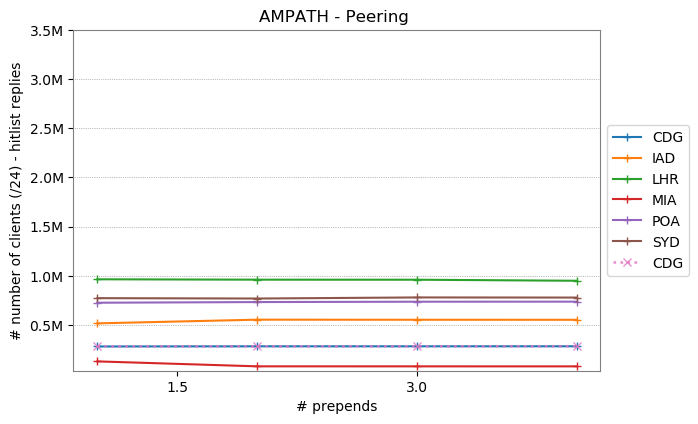

In [38]:

df_all.num_prepend = df_all.num_prepend.astype(int)
df_ampath = df_all[df_all['bgp_policy_location'].str.contains("ampath")].copy()
df_ampath_community = df_ampath[df_ampath.bgp_policy.str.contains("community")]
df_ampath_prepend = df_ampath[~df_ampath.bgp_policy.str.contains("community")]

available_nodes = df_prepend.columns.to_list()
available_nodes.remove('unknown')
available_nodes.remove('HND')
available_nodes

(fig,ax) = init_fig(6,4)

for prepend_site in available_nodes:
    
    data = df_ampath_community[df_ampath_community.site.str.contains(prepend_site)]
    a = pd.pivot_table(data,index=["site"],values=['count'],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1)
    data = a.T
    data.plot(kind="line",
                  marker="+",
                  ax= ax)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    

for prepend_site in available_nodes:
    
    data = df_ampath_prepend[df_ampath_prepend.site.str.contains(prepend_site)]
    a = pd.pivot_table(data,index=["site"],values=['count'],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1)
    data = a.T
    data.plot(kind="line",
                  marker="x",
                  ax= ax,
                  alpha = 1.8,
                  linestyle='dotted',
                  linewidth=1.9
             )
    ax.set_title("AMPATH - Peering "); 
    
    ax.set_ylim(ymax=3500000);
    ax.set_xlabel('# prepends');
    ax.set_ylabel('# number of clients (/24) - hitlist replies');
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    
    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
    filename = "/Users/joaoceron/work/WORKING/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/ampath-prepending.pdf"
    fig.savefig(filename, bbox_inches='tight', dpi=1200)

In [ ]:

df_all.num_prepend = df_all.num_prepend.astype(int)
df_ampath = df_all[df_all['bgp_policy_location'].str.contains("vultr")].copy()
df_ampath_community = df_ampath[df_ampath.bgp_policy.str.contains("community")]
df_ampath_prepend = df_ampath[~df_ampath.bgp_policy.str.contains("community")]

available_nodes = df_prepend.columns.to_list()
available_nodes.remove('unknown')
available_nodes.remove('HND')
available_nodes

(fig,ax) = init_fig(6,4)

for prepend_site in available_nodes:
    
    data = df_ampath_community[df_ampath_community.site.str.contains(prepend_site)]
    a = pd.pivot_table(data,index=["site"],values=['count'],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1)
    data = a.T
    data.plot(kind="line",
                  marker="+",
                  ax= ax)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    

for prepend_site in available_nodes:
    
    data = df_ampath_prepend[df_ampath_prepend.site.str.contains(prepend_site)]
    a = pd.pivot_table(data,index=["site"],values=['count'],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1)
    data = a.T
    data.plot(kind="line",
                  marker="x",
                  ax= ax,
                  alpha = 1.8,
                  linestyle='dotted',
                  linewidth=1.9
             )
    ax.set_ylim(ymax=3500000);

    ax.set_title("VULTR  Peering");   
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax.set_ylabel('# number of clients (/24) - hitlist replies');

    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
    filename = "/Users/joaoceron/work/WORKING/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/vultr-prepending.pdf"
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    fig.savefig(filename, bbox_inches='tight', dpi=1200)